# Sentiment Analysis:  Feature-Based Classification

In [ ]:
pip install --upgrade datasets fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [ ]:
from datasets import load_dataset

dataset = load_dataset('amazon_polarity')

# Dataset structure
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

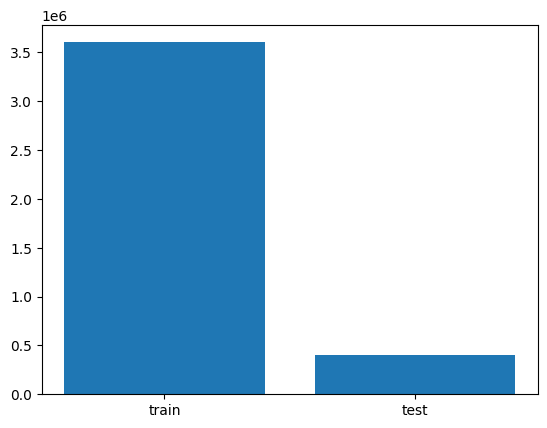

In [ ]:
# Size of the training & testing set
train_set = dataset['train']
test_set = dataset['test']

from matplotlib import pyplot as plt

plt.bar(['train', 'test'], [len(train_set), len(test_set)])
plt.show()

In [ ]:
# plotting the distrubtion of labels
train_df = train_set.to_pandas()
train_df.head(5)

,label,title,content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


<Axes: xlabel='label'>

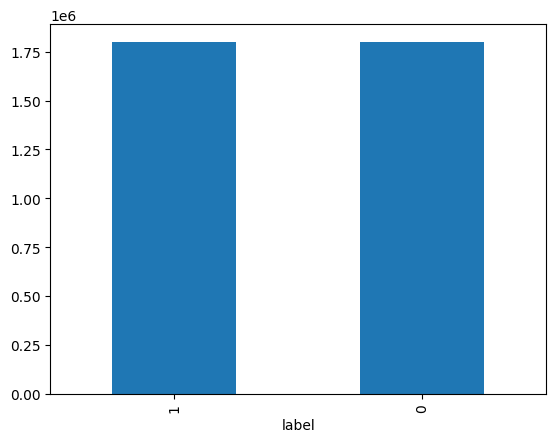

In [ ]:
train_df.label.value_counts().plot(kind='bar')

<Axes: xlabel='label'>

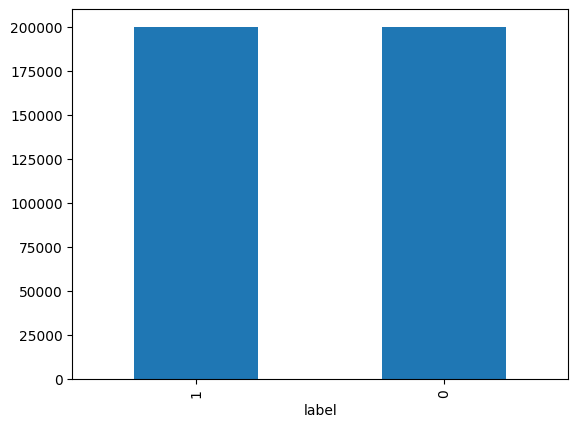

In [ ]:
test_df = test_set.to_pandas()
test_df.label.value_counts().plot(kind='bar')

In [ ]:
from collections import Counter

all_text = ' '.join(train_df['title'].str.lower())
Counter(all_text.split(' ')).most_common(5)

[('the', 488026),
 ('a', 423730),
 ('not', 298203),
 ('of', 257353),
 ('great', 251930)]

In [ ]:
train_set


Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 3600000
})

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# min_df = 2   Only include words that appear in at least 2 documents.
# Words that appear in only one document are excluded.
# Helps remove noise, typos, or overly specific words that don’t generalize.
# Reducing dimensionality and filter out rare/uninformative terms

# max_df by default = 1.0 ignore higher frequency terms (stop-words)
vectorizer = CountVectorizer(
      lowercase=True,
      analyzer='word',
      min_df = 2,
      max_df = 1.0,
      #stop_words="english"
      )
X_train = vectorizer.fit_transform(train_set['content'])
X_test = vectorizer.transform(test_set['content'])

print("Shape of matrix X_train: ",X_train.shape)
print("Shape of matrix X_test : ",X_test.shape)

Shape of matrix X_train:  (3600000, 355610)
Shape of matrix X_test :  (400000, 355610)


## Splitting the Dataset

In [ ]:
import numpy as np

y_train = np.array(train_set['label'])
y_test  = np.array(test_set['label'])

print("Shape of y_train (n_samples,)",y_train.shape)
print("Shape of y_test (n_samples,)",y_test.shape)

Shape of y_train (n_samples,) (3600000,)
Shape of y_test (n_samples,) (400000,)


## Training

In [ ]:
from sklearn.linear_model import LogisticRegression


# Intialize a LogisticRegression Classifier
clf = LogisticRegression(
    solver="liblinear",
    random_state=0,
    verbose=10,
    max_iter=100,
    )

print(clf.set_params())

m = 100000
# Training
classifier = clf.fit(X_train[:m], y_train[:m])

LogisticRegression(random_state=0, solver='liblinear', verbose=10)
[LibLinear]

In [ ]:
print("The accuracy of LR on the train set:",clf.score(X_train, y_train))
print("The accuracy of LR on the test  set:",clf.score(X_test, y_test))

The accuracy of LR on the train set: 0.8801158333333333
The accuracy of LR on the test  set: 0.87594


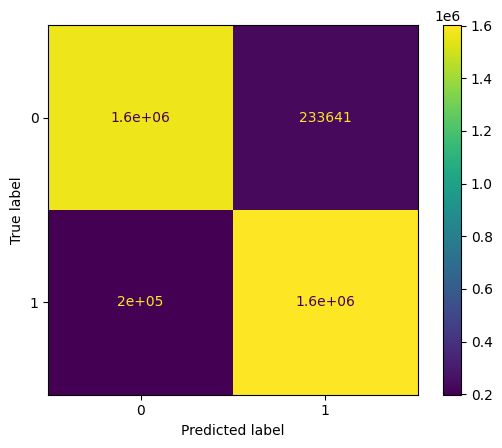

In [ ]:
# How well the model fits the data it has already seen.

from sklearn.metrics import ConfusionMatrixDisplay
_ = ConfusionMatrixDisplay.from_estimator(classifier, X_train, y_train)

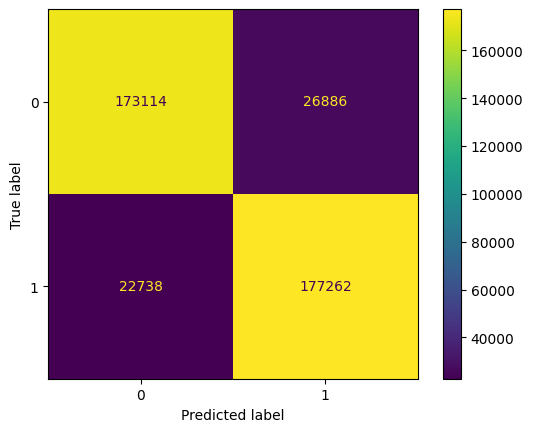

In [ ]:
# How well your model generalizes to unseen data.
from sklearn.metrics import ConfusionMatrixDisplay
_ = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)

In [ ]:
import numpy as np

probs = classifier.predict_proba(X_test)
confidences = probs.max(axis=1)


y_pred = classifier.predict(X_test)
y_true = y_test

correct_conf = confidences[y_pred == y_true]
incorrect_conf = confidences[y_pred != y_true]

print(correct_conf)
print(incorrect_conf)



[0.98846508 0.99895394 0.58411889 ... 0.58793804 0.99306196 0.99541848]
[0.63560689 0.54126962 0.6121541  ... 0.70598387 0.50397036 0.64561062]


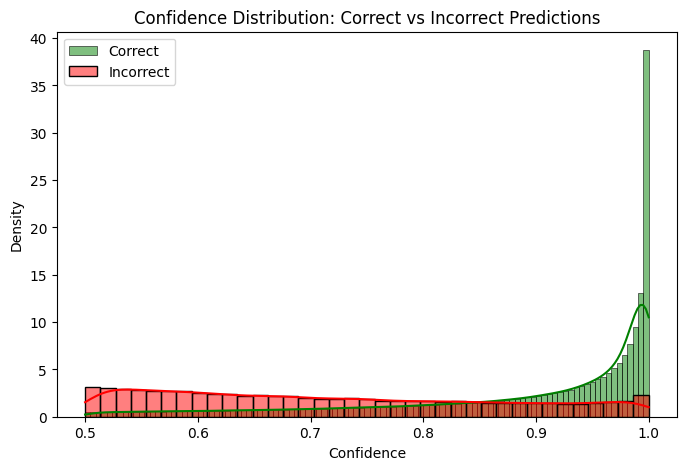

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot
plt.figure(figsize=(8, 5))

sns.histplot(correct_conf, color="green", label="Correct", kde=True, stat="density")
sns.histplot(incorrect_conf, color="red", label="Incorrect", kde=True, stat="density")

plt.xlabel("Confidence")
plt.ylabel("Density")
plt.title("Confidence Distribution: Correct vs Incorrect Predictions")
plt.legend()
plt.show()


In [ ]:
from sklearn.svm import l1_min_c

# The  minimum C for L1 to start selecting features
C_min = l1_min_c(X_train, y_train, loss='log')

In [ ]:
C_min

np.float64(5.080397287067849e-06)

In [ ]:
# Intialize a LogisticRegression Classifier
clf = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    random_state=0,
    verbose=10,
    max_iter=100,
    C= float(C_min) * 2
    )

# Checking parameters
print(clf.get_params())
# Training
clf.fit(X_train, y_train)


{'C': 1.0160794574135697e-05, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 10, 'warm_start': False}
[LibLinear]

LogisticRegression(C=1.0160794574135697e-05, penalty='l1', random_state=0,
                   solver='liblinear', verbose=10)

In [ ]:
clf.score(X_test, y_test)

0.58219

In [ ]:

# 3. Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
print(f"length of feaure names is {len(feature_names)}")

coefs = clf.coef_[0]
print(coefs)


length of feaure names is 114238
[0. 0. 0. ... 0. 0. 0.]


In [ ]:

# 4. Get indices of the 100 most relevant (non-zero, highest absolute value) features
nonzero_indices = np.flatnonzero(coefs)
print(nonzero_indices)
sorted_indices = nonzero_indices[np.argsort(np.abs(coefs[nonzero_indices]))[::-1]]
top_100_indices = sorted_indices[:100]

# 5. Print top 100 relevant words with their coefficients
top_words = [(feature_names[i], coefs[i]) for i in top_100_indices]
for word, coef in top_words:
    print(f"{word:20} {coef:.4f}")

[44676]
great                0.3504
